ok, first i will work off of recordings in order to

1) get scoring working

2) make a simple classifier for state-space

In [4]:
import os, subprocess

extract frames from video

In [ ]:
video_path = '../resources/taikotemp/recordings/test_0.avi'
extract_path = '../resources/taikotemp/recordings/extracted'
file_info = ''

if not os.path.exists(extract_path):
    os.mkdir(extract_path)

fps_cmd = 'ffmpeg -hide_banner -i {}'.format(video_path)

try:
    subprocess.check_output(fps_cmd, stderr=subprocess.STDOUT, shell=True)
except subprocess.CalledProcessError as e:
    file_info = e.output
file_info = file_info.decode('utf-8')
file_info = file_info.split('\n')

fps = None

for line in file_info:
    if 'fps' in line:
        split_line = line.split(" ")
        fps = split_line[split_line.index('fps,')-1]

if fps is not None:
    extract_command = "ffmpeg -i {} -r {} {}/out-%d.png".format(video_path, fps, extract_path)
    subprocess.call(extract_command, shell=True)


In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
mask_path = '../resources/taikotemp/what_i_want/'

def clean_pic(fname):
    starting_pic = Image.open(fname, 'r')
    as_array = np.asarray(starting_pic)
    as_array = as_array[:,:,:3]
    return as_array

def clean_array_mask(idx):
    start_pic = clean_pic(mask_path + '{}.png'.format(idx))
    
    mask = start_pic == [0, 255, 0]
    to_return = start_pic.copy()
    to_return[mask] = -1
    
    return to_return

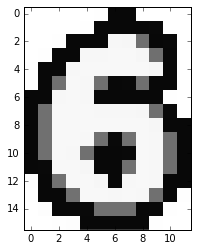

In [82]:
plt.imshow(clean_array_mask(6), interpolation ='none')
plt.show()

In [74]:
masks = [clean_array_mask(i) for i in range(10)]

In [84]:
test_frame = clean_pic(extract_path + '/out-6549.png')

In [4]:
def show_screen(scrot_as_array):
    plt.figure(figsize=(5,10))
    plt.axis('off')
    plt.imshow(scrot_as_array, interpolation ='none')
    plt.show()

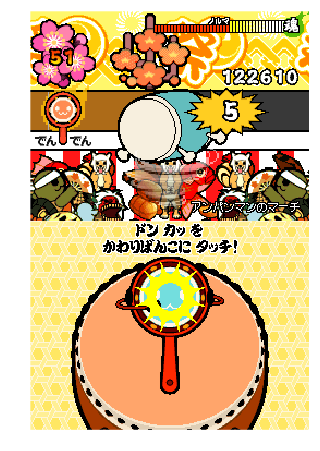

In [85]:
show_screen(test_frame)

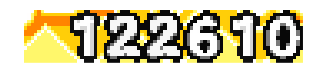

In [88]:
score_crop = test_frame[52:68,-94:-10,:]
show_screen(score_crop)

In [259]:
last_score = 0
num_detect_thresh = 80

def update_score(current_frame):
    score_crop = current_frame[52:68,-94:-10,:]
    read_num = []
    # temp = [] # for figuring out thresholds
    for i in reversed(range(7)):
        looking_at = score_crop[:, 12 * i:12 * (i + 1), :]
        #  mse = [np.sum((looking_at - masks[j]) ** 2) / 576 for j in range(10)]
        # trying an abs_diff instead
        abs_diff = [np.mean(np.fabs(looking_at - masks[j])) for j in range(10)]
        most_likely = np.argmin(abs_diff)
        # print(most_likely, mse[most_likely])
        if abs_diff[most_likely] > num_detect_thresh:
            break
        read_num += [most_likely]
        # temp += [mse[most_likely]]
        # temp += [abs_diff[most_likely]]
    new_score = sum([n * 10 ** i for i, n in enumerate(read_num)])
    # score can't go down, and differs by at least 100 and at most 25k?
    # (stupid things where you have to mash and u get bonus for complete)
    score_diff = new_score - last_score
    if score_diff < 100 or score_diff > 25000:
        new_score = last_score
    return (new_score, score_diff, new_score == last_score)

In [260]:
last_score = 0
test_all = []
for e_id in range(1, 7036, 1):
    t_frame = clean_pic(extract_path + '/out-{}.png'.format(e_id))
    scores = update_score(t_frame)
    last_score = scores[0]
    test_all += [scores]   

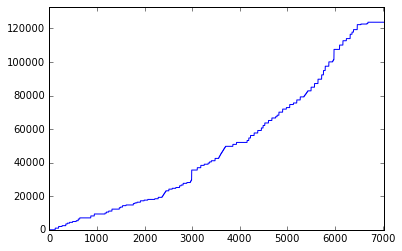

In [261]:
plt.plot([t[0] for t in test_all])
plt.axis([0,7036,-1,133000])
plt.show()

now for state-space. your score gets bumped the frame after a hit

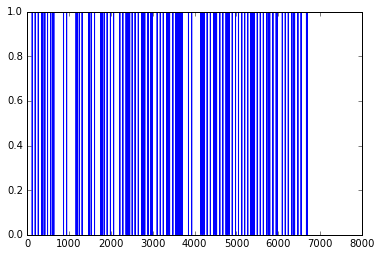

In [263]:
plt.plot([t[2] for t in test_all])


In [268]:
hit_inds = [int(not t[2]) for t in test_all]

In [270]:
hit_inds = np.asarray(hit_inds)

In [273]:
press_inds = np.roll(hit_inds, -1)

In [275]:
hit_deltas = [t[1] for t in test_all]

here is how scoring works
http://taikotime.blogspot.com/2010/08/advanced-rules.html

In [276]:
set(hit_deltas)

{-122280,
 -119640,
 -100000,
 -18100,
 -10000,
 0,
 300,
 360,
 410,
 490,
 580,
 690,
 720,
 740,
 830,
 910,
 990,
 1160,
 1280,
 1390,
 1480,
 1490,
 1820,
 2180,
 2580,
 2970,
 6000,
 100000,
 100830}

In [280]:
hit_delt = np.asarray(hit_deltas)

In [284]:
np.where((hit_delt > 0) & (hit_delt < 10000))[0] - 1

array([ 119,  191,  264,  342,  373,  420,  485,  561,  603,  635,  867,
        941, 1167, 1197, 1244, 1312, 1466, 1494, 1535, 1608, 1761, 1795,
       1839, 1910, 1988, 2064, 2212, 2284, 2363, 2371, 2378, 2385, 2392,
       2398, 2405, 2412, 2419, 2427, 2433, 2441, 2447, 2508, 2578, 2654,
       2733, 2766, 2808, 2886, 2959, 2964, 2972, 2979, 2987, 3105, 3179,
       3251, 3333, 3364, 3401, 3479, 3555, 3560, 3568, 3575, 3581, 3589,
       3595, 3603, 3610, 3619, 3627, 3635, 3643, 3651, 3659, 3666, 3673,
       3683, 3691, 3699, 3853, 3929, 4152, 4188, 4224, 4300, 4376, 4452,
       4488, 4524, 4601, 4673, 4751, 4782, 4821, 4899, 4977, 5048, 5126,
       5196, 5269, 5348, 5352, 5362, 5369, 5376, 5385, 5392, 5399, 5407,
       5414, 5422, 5428, 5497, 5569, 5642, 5719, 5757, 5794, 5870, 5949,
       5956, 5963, 5972, 5978, 6095, 6166, 6238, 6318, 6357, 6388, 6467,
       6544, 6672, 6691], dtype=int64)

In [305]:
a_frame = clean_pic(extract_path + '/out-75.png')

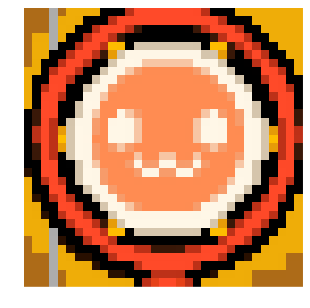

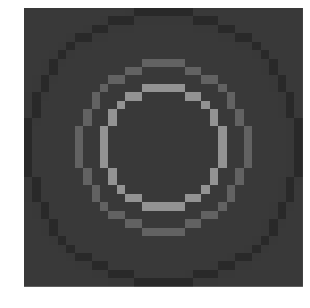

In [316]:
show_screen(test_frame[75:108,13:46,:])
show_screen(a_frame[75:108,13:46,:])


In [315]:
a_frame[75:108,13:46,:].shape

(33, 33, 3)

In [327]:
np.average(np.average(a_frame[75:108,13:46,:], axis=1), axis=0)

array([ 61.15059688,  61.15059688,  61.15059688])

In [328]:
avg_circle_color = np.zeros([7035, 33, 3])

In [5]:
all_frames = [clean_pic(extract_path + '/out-{}.png'.format(e_id)) for e_id in range(1, 7036)]

In [354]:
for i, f in enumerate(all_frames):
    avg_circle_color[i] = np.average(f[75:108,13:46,:], axis=1)
    

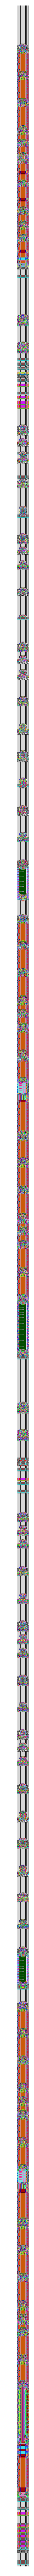

In [363]:
plt.figure(figsize=(10,100))
plt.axis('off')
plt.imshow(avg_circle_color, interpolation ='none')
plt.show()

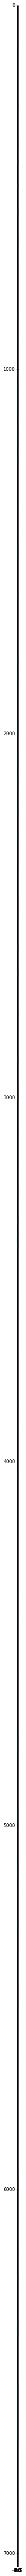

In [366]:
plt.figure(figsize=(10,100))

plt.imshow(np.average(avg_circle_color, axis=1), interpolation='none')

In [367]:
avg_avg = np.average(avg_circle_color, axis=1)

In [375]:
avg_diff = np.diff(avg_avg, axis=0)

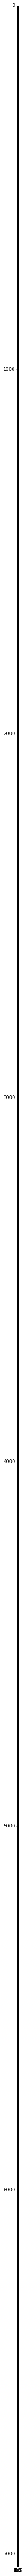

In [376]:
plt.figure(figsize=(10,100))
plt.imshow(avg_diff, interpolation='none')

In [393]:
floored = np.floor_divide(np.mean(avg_diff, axis=1), 8)
floor_set = set(list(floored))
print(len(floor_set), floor_set)

10 {-0.0, 1.0, 2.0, 3.0, 4.0, 5.0, -2.0, -4.0, -3.0, -1.0}


In [394]:
len(hit_deltas)

7035

In [397]:
hit_inds = np.where((hit_delt > 0) & (hit_delt < 5000))[0]
hit_score_delts = list(hit_delt[hit_inds])

In [398]:
hit_score_delts

[990,
 990,
 490,
 990,
 490,
 490,
 490,
 490,
 990,
 690,
 1160,
 1160,
 580,
 580,
 580,
 1160,
 830,
 410,
 830,
 410,
 830,
 410,
 410,
 830,
 410,
 410,
 410,
 830,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 990,
 490,
 490,
 990,
 490,
 990,
 490,
 360,
 360,
 360,
 360,
 1390,
 1390,
 690,
 690,
 690,
 690,
 1390,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 360,
 1160,
 1160,
 1160,
 1490,
 1490,
 1490,
 1490,
 1490,
 1490,
 1490,
 1490,
 1490,
 740,
 910,
 1820,
 1820,
 910,
 1820,
 910,
 1820,
 1820,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 300,
 2180,
 2180,
 2580,
 2580,
 2580,
 2580,
 2580,
 360,
 360,
 360,
 360,
 2580,
 2580,
 1280,
 2580,
 1280,
 1480,
 2970,
 360,
 360,
 720]

new idea for state space - split learning into two

main non-bg color tells you what button (or buttons) to press

how close is that color to center of hit zone gets discretized for q-learning

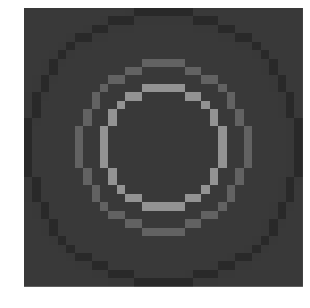

In [7]:
# bg
show_screen(all_frames[0][75:108,13:46,:])

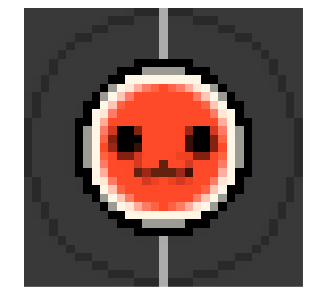

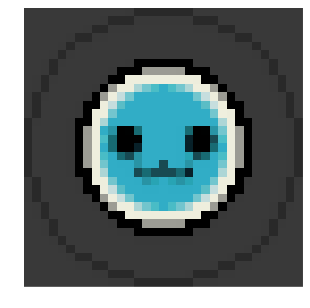

In [21]:
show_screen(all_frames[4749][75:108,13:46,:])
show_screen(all_frames[4973][75:108,13:46,:])

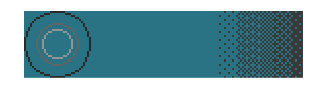

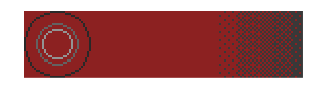

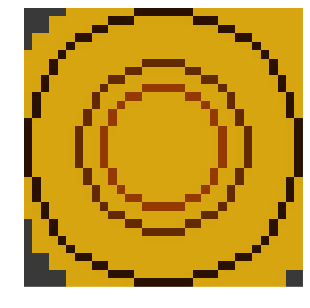

In [32]:
# but i want to avoid these..
show_screen(all_frames[4047][75:108,13:150,:])
show_screen(all_frames[4079][75:108,13:150,:])
# and this
show_screen(all_frames[6218][75:108,13:46,:])

In [6]:
o_f = all_frames[4749][75:108,13:46,:]

In [39]:
np.version.version
# lol, time to upgrade

'1.11.2'

In [12]:
np.version.version
# need the axis param for np.unique

'1.13.1'

In [13]:
colors, counts = np.unique(np.reshape(o_f, [-1, 3]), axis=0, return_counts=True)

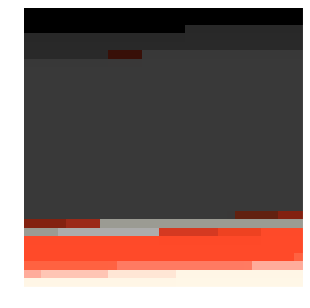

In [20]:
histo_arr = np.repeat(colors, counts, axis=0)
show_screen(np.reshape(histo_arr, [33, 33, 3]))

we want biggest non-grayscale color : )

In [43]:
np.diff(np.diff(colors)) != 0

array([[False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

In [59]:
non_gray_mask = np.ravel(np.diff(np.diff(colors)) != 0)

In [61]:
colors[non_gray_mask]

array([[ 57,  16,   8],
       [ 99,  33,  16],
       [132,  33,  16],
       [156,  41,  24],
       [156, 156, 148],
       [214,  57,  33],
       [239,  66,  33],
       [255,  74,  41],
       [255,  99,  66],
       [255, 123,  99],
       [255, 173, 156],
       [255, 198, 181],
       [255, 231, 214],
       [255, 247, 231]], dtype=uint8)

In [75]:
# normalize to 99 just for kicks
norm_c = counts[non_gray_mask]
norm_c = np.ceil(100 * norm_c / sum(norm_c))

In [84]:
norm_c[np.argmax(norm_c)] -= (sum(norm_c) - 100)
norm_c = norm_c.astype(int)

In [87]:
pretty = np.repeat(colors[non_gray_mask], norm_c, axis=0)

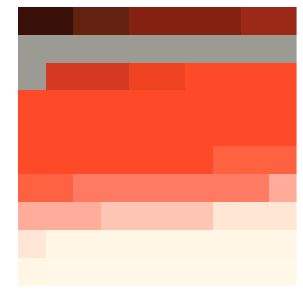

In [90]:
show_screen(np.reshape(pretty, [10, 10, 3]))

In [110]:
def get_frame_color(inp_frame, output_size = 100):
    colors, counts = np.unique(np.reshape(inp_frame, [-1, 3]), axis=0, return_counts=True)
    non_gray_mask = np.ravel(np.diff(np.diff(colors)) != 0)
    
    if sum(non_gray_mask) == 0:
        return np.zeros([output_size, 3])

    norm_c = counts[non_gray_mask]
    norm_c = np.ceil(output_size * norm_c / sum(norm_c))
    norm_c[np.argmax(norm_c)] -= (sum(norm_c) - output_size)
    norm_c = norm_c.astype(int)
    
    pretty = np.repeat(colors[non_gray_mask], norm_c, axis=0)
    return pretty

In [111]:
color_hists = np.zeros([7035, 100, 3])

In [112]:
for i, f in enumerate(all_frames):
    try:
        color_hists[i] = get_frame_color(f[75:108,13:46,:])
    except:
        print(i)

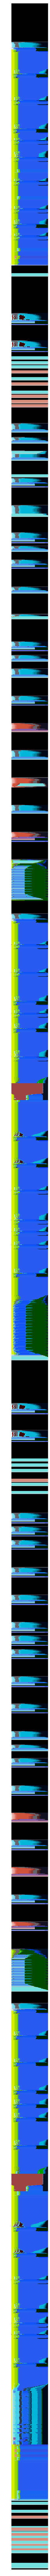

In [115]:
plt.figure(figsize=(20,150))
plt.axis('off')
plt.imshow(color_hists, interpolation ='none')
plt.show()

cool, now we will just cluster these around true blue and orange